In [182]:
import argparse
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer

def load_model_and_tokenizer(checkpoint_path):
    model = AutoModelForCausalLM.from_pretrained(checkpoint_path)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
    return model, tokenizer

def plot_activation_maps(model, input_str, tokenizer, output_dir):
    inputs = tokenizer(input_str, return_tensors="pt")
    input_ids = inputs['input_ids'][0]
    input_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    # Get activations
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True, output_attentions=True)
    
    hidden_states = outputs.hidden_states
    attentions = outputs.attentions
    
    # Print shapes for debugging
    print("Hidden states shape:", [h.shape for h in hidden_states])
    print("Attentions shape:", [a.shape for a in attentions])
    
    num_layers = len(hidden_states)
    
    # Determine the number of attention heads
    if attentions and len(attentions) > 0:
        # Check if attentions is a list of tensors or a single tensor
        if isinstance(attentions[0], torch.Tensor):
            num_heads = attentions[0].shape[1] if len(attentions[0].shape) > 3 else 1
        else:
            num_heads = 1
    else:
        num_heads = 1
    print(f"Number of attention heads: {num_heads}")
    
    # Calculate the total number of subplots
    total_plots = num_layers * (1 + num_heads)  # 1 activation plot + num_heads attention plots per layer
    
    # Calculate rows and columns for subplots
    cols = num_heads + 1  # 1 for activation, num_heads for attention
    rows = num_layers
    
    # Create figure
    fig = plt.figure(figsize=(5*cols, 5*rows))
    gs = fig.add_gridspec(rows, cols + 1, width_ratios=[*[20]*cols, 1])  # +1 for colorbar
    fig.suptitle("Activation and Attention Maps", fontsize=16)
    
    # Create empty lists to store all activation and attention data
    all_activations = []
    all_attentions = []
    
    for layer_idx in range(num_layers):
        activation_data = hidden_states[layer_idx][0].T.cpu().numpy()
        all_activations.append(activation_data)
        
        # Plot MLP activations
        ax_act = fig.add_subplot(gs[layer_idx, 0])
        im_act = ax_act.imshow(activation_data, aspect='auto', cmap="viridis")
        ax_act.set_title(f"MLP Activation\nLayer {layer_idx}")
        ax_act.set_xlabel("Input Sequence")
        ax_act.set_ylabel("Hidden Dimension")
        ax_act.set_xticks(range(len(input_tokens)))
        ax_act.set_xticklabels(input_tokens, rotation=90)
        
        # Plot Attention maps for each head
        for head in range(num_heads):
            if layer_idx < len(attentions):
                if num_heads > 1:
                    attention_data = attentions[layer_idx][0, head].cpu().numpy()
                else:
                    attention_data = attentions[layer_idx][0].cpu().numpy()
                all_attentions.append(attention_data)
                ax_att = fig.add_subplot(gs[layer_idx, head + 1])
                im_att = ax_att.imshow(attention_data, aspect='auto', cmap="viridis")
                ax_att.set_title(f"Attention Map\nLayer {layer_idx}, Head {head}")
                ax_att.set_xlabel("Key")
                ax_att.set_ylabel("Query")
                ax_att.set_xticks(range(len(input_tokens)))
                ax_att.set_yticks(range(len(input_tokens)))
                ax_att.set_xticklabels(input_tokens, rotation=90)
                ax_att.set_yticklabels(input_tokens, rotation=0)
    
    # Add colorbars
    all_activations = np.concatenate(all_activations)
    all_attentions = np.concatenate(all_attentions) if all_attentions else np.array([])
    
    cax = fig.add_subplot(gs[:, -1])
    cbar = fig.colorbar(im_act, cax=cax, label='Activation/Attention Value')
    
    # Set the colorbar limits to the min and max of all data
    vmin = min(all_activations.min(), all_attentions.min() if all_attentions.size > 0 else all_activations.min())
    vmax = max(all_activations.max(), all_attentions.max() if all_attentions.size > 0 else all_activations.max())
    im_act.set_clim(vmin, vmax)
    if 'im_att' in locals():
        im_att.set_clim(vmin, vmax)
    
    plt.tight_layout()
    plt.show()
    # Uncomment the following line to save the figure
    # plt.savefig(os.path.join(output_dir, "activation_attention_maps.png"), dpi=300, bbox_inches='tight')
    plt.close()

In [183]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import TwoSlopeNorm

def compare_checkpoints(model1, model2, output_dir):
    diff_norms = {}
    all_diffs = []
    param_shapes = {}
    
    # Collect differences, norms, and shapes
    for (name1, param1), (name2, param2) in zip(model1.named_parameters(), model2.named_parameters()):
        assert name1 == name2, f"Parameter names do not match: {name1} vs {name2}"
        
        diff = param2.data - param1.data
        diff_np = diff.detach().cpu().numpy()
        all_diffs.append(diff_np)
        diff_norm = np.linalg.norm(diff_np)
        diff_norms[name1] = diff_norm
        param_shapes[name1] = diff_np.shape
    
    all_diffs_flat = np.concatenate([d.flatten() for d in all_diffs])
    
    # Calculate number of subplots
    n_params = len(diff_norms)
    n_cols = 4  # You can adjust this
    n_rows = (n_params + n_cols - 1) // n_cols + 1  # +1 for the histogram
    
    # Create figure
    fig = plt.figure(figsize=(5*n_cols, 5*n_rows))
    fig.suptitle("Parameter Differences between Checkpoints", fontsize=16)
    
    # Find global min and max for consistent color scaling
    vmin, vmax = np.percentile(all_diffs_flat, [1, 99])
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    
    # Plot differences for each parameter
    for idx, (name, diff) in enumerate(zip(diff_norms.keys(), all_diffs)):
        ax = fig.add_subplot(n_rows, n_cols, idx + 1)
        
        if len(param_shapes[name]) == 1:  # For 1D tensors
            im = ax.imshow(diff.reshape(1, -1), cmap='coolwarm', norm=norm, aspect='auto')
        else:
            im = ax.imshow(diff, cmap='coolwarm', norm=norm)
        
        ax.set_title(f"{name}\n{param_shapes[name]}", fontsize=8)
        ax.axis('off')  # Turn off axis for cleaner look
        
        # Add colorbar for each subplot
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Plot histogram of all differences
    ax_hist = fig.add_subplot(n_rows, n_cols, n_params + 1)
    ax_hist.hist(all_diffs_flat, bins=50, edgecolor='black')
    ax_hist.set_title("Distribution of All Parameter Differences")
    ax_hist.set_xlabel("Difference Value")
    ax_hist.set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()
    # Uncomment the following line to save the figure
    # plt.savefig(os.path.join(output_dir, "parameter_differences_detailed.png"), dpi=300, bbox_inches='tight')
    plt.close()

    # Print summary statistics
    print("\nSummary of Parameter Differences:")
    for name, norm in diff_norms.items():
        print(f"{name} {param_shapes[name]}: {norm}")
    
    total_diff = sum(diff_norms.values())
    print("\nTotal L2 Norm of Differences:", total_diff)
    
    # Additional statistics
    print(f"Mean Difference: {np.mean(all_diffs_flat)}")
    print(f"Median Difference: {np.median(all_diffs_flat)}")
    print(f"Max Difference: {np.max(np.abs(all_diffs_flat))}")
    print(f"Standard Deviation of Differences: {np.std(all_diffs_flat)}")
    
    # Percentage of parameters changed
    changed_params = np.sum(np.abs(all_diffs_flat) > 1e-6)  # Threshold can be adjusted
    total_params = len(all_diffs_flat)
    print(f"Percentage of Parameters Changed: {changed_params / total_params * 100:.2f}%")

    return (total_diff, all_diffs_flat)

In [184]:
checkpoint_dir = '/home/hoyeon/circuit-analysis/checkpoints'
exp_name = 'L2_H2_E16_wd1_len10_bsize1_code10_lr-4_pure-mixed'
step = [999, 1000]

In [185]:
checkpoint1_path = os.path.join(checkpoint_dir, exp_name, f"checkpoint-{step[0]}")
checkpoint2_path = os.path.join(checkpoint_dir, exp_name, f"checkpoint-{step[1]}")

model1, tokenizer = load_model_and_tokenizer(checkpoint1_path)
model2, tokenizer = load_model_and_tokenizer(checkpoint2_path)

Hidden states shape: [torch.Size([1, 10, 16]), torch.Size([1, 10, 16]), torch.Size([1, 10, 16])]
Attentions shape: [torch.Size([1, 2, 10, 10]), torch.Size([1, 2, 10, 10])]
Number of attention heads: 2


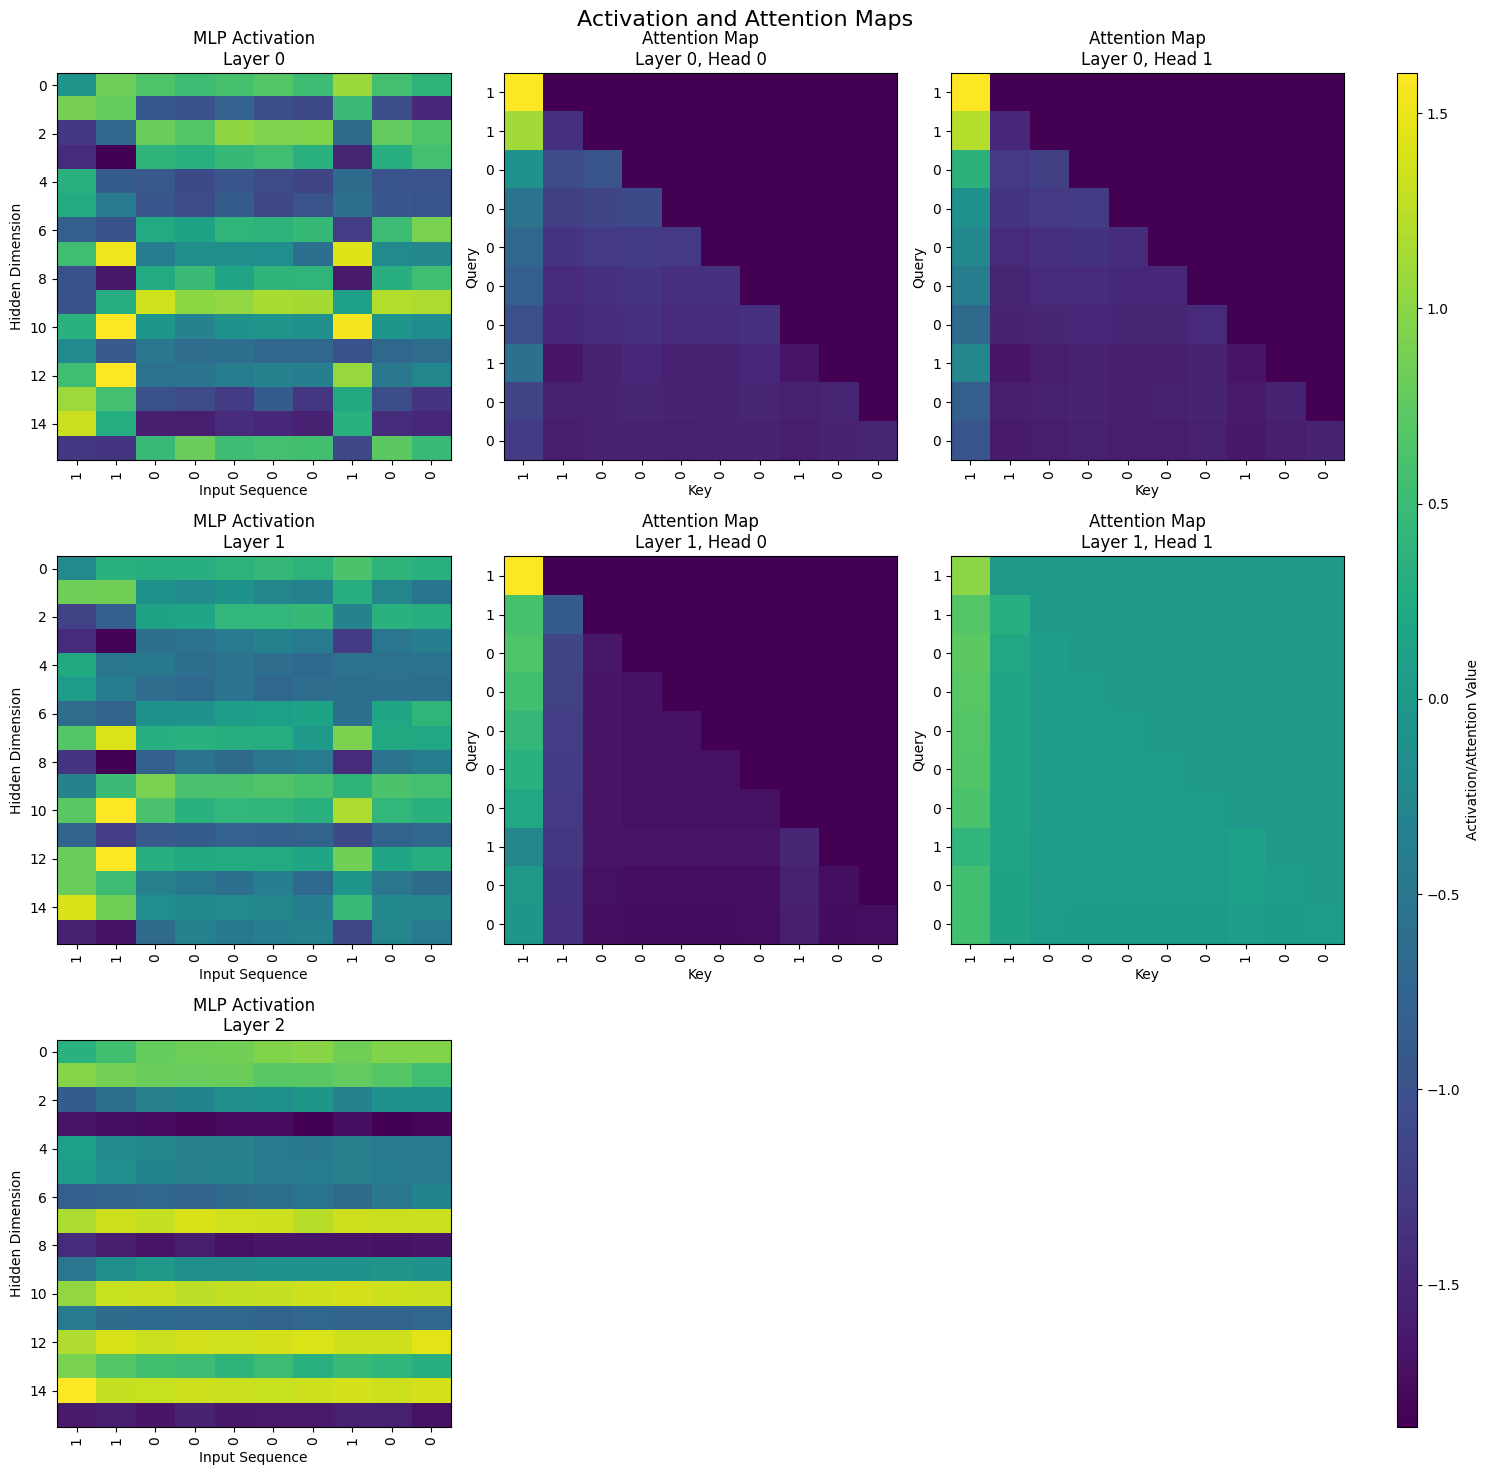

In [186]:
input_str = '1100000100'

plot_activation_maps(model1, input_str, tokenizer, output_dir=None)

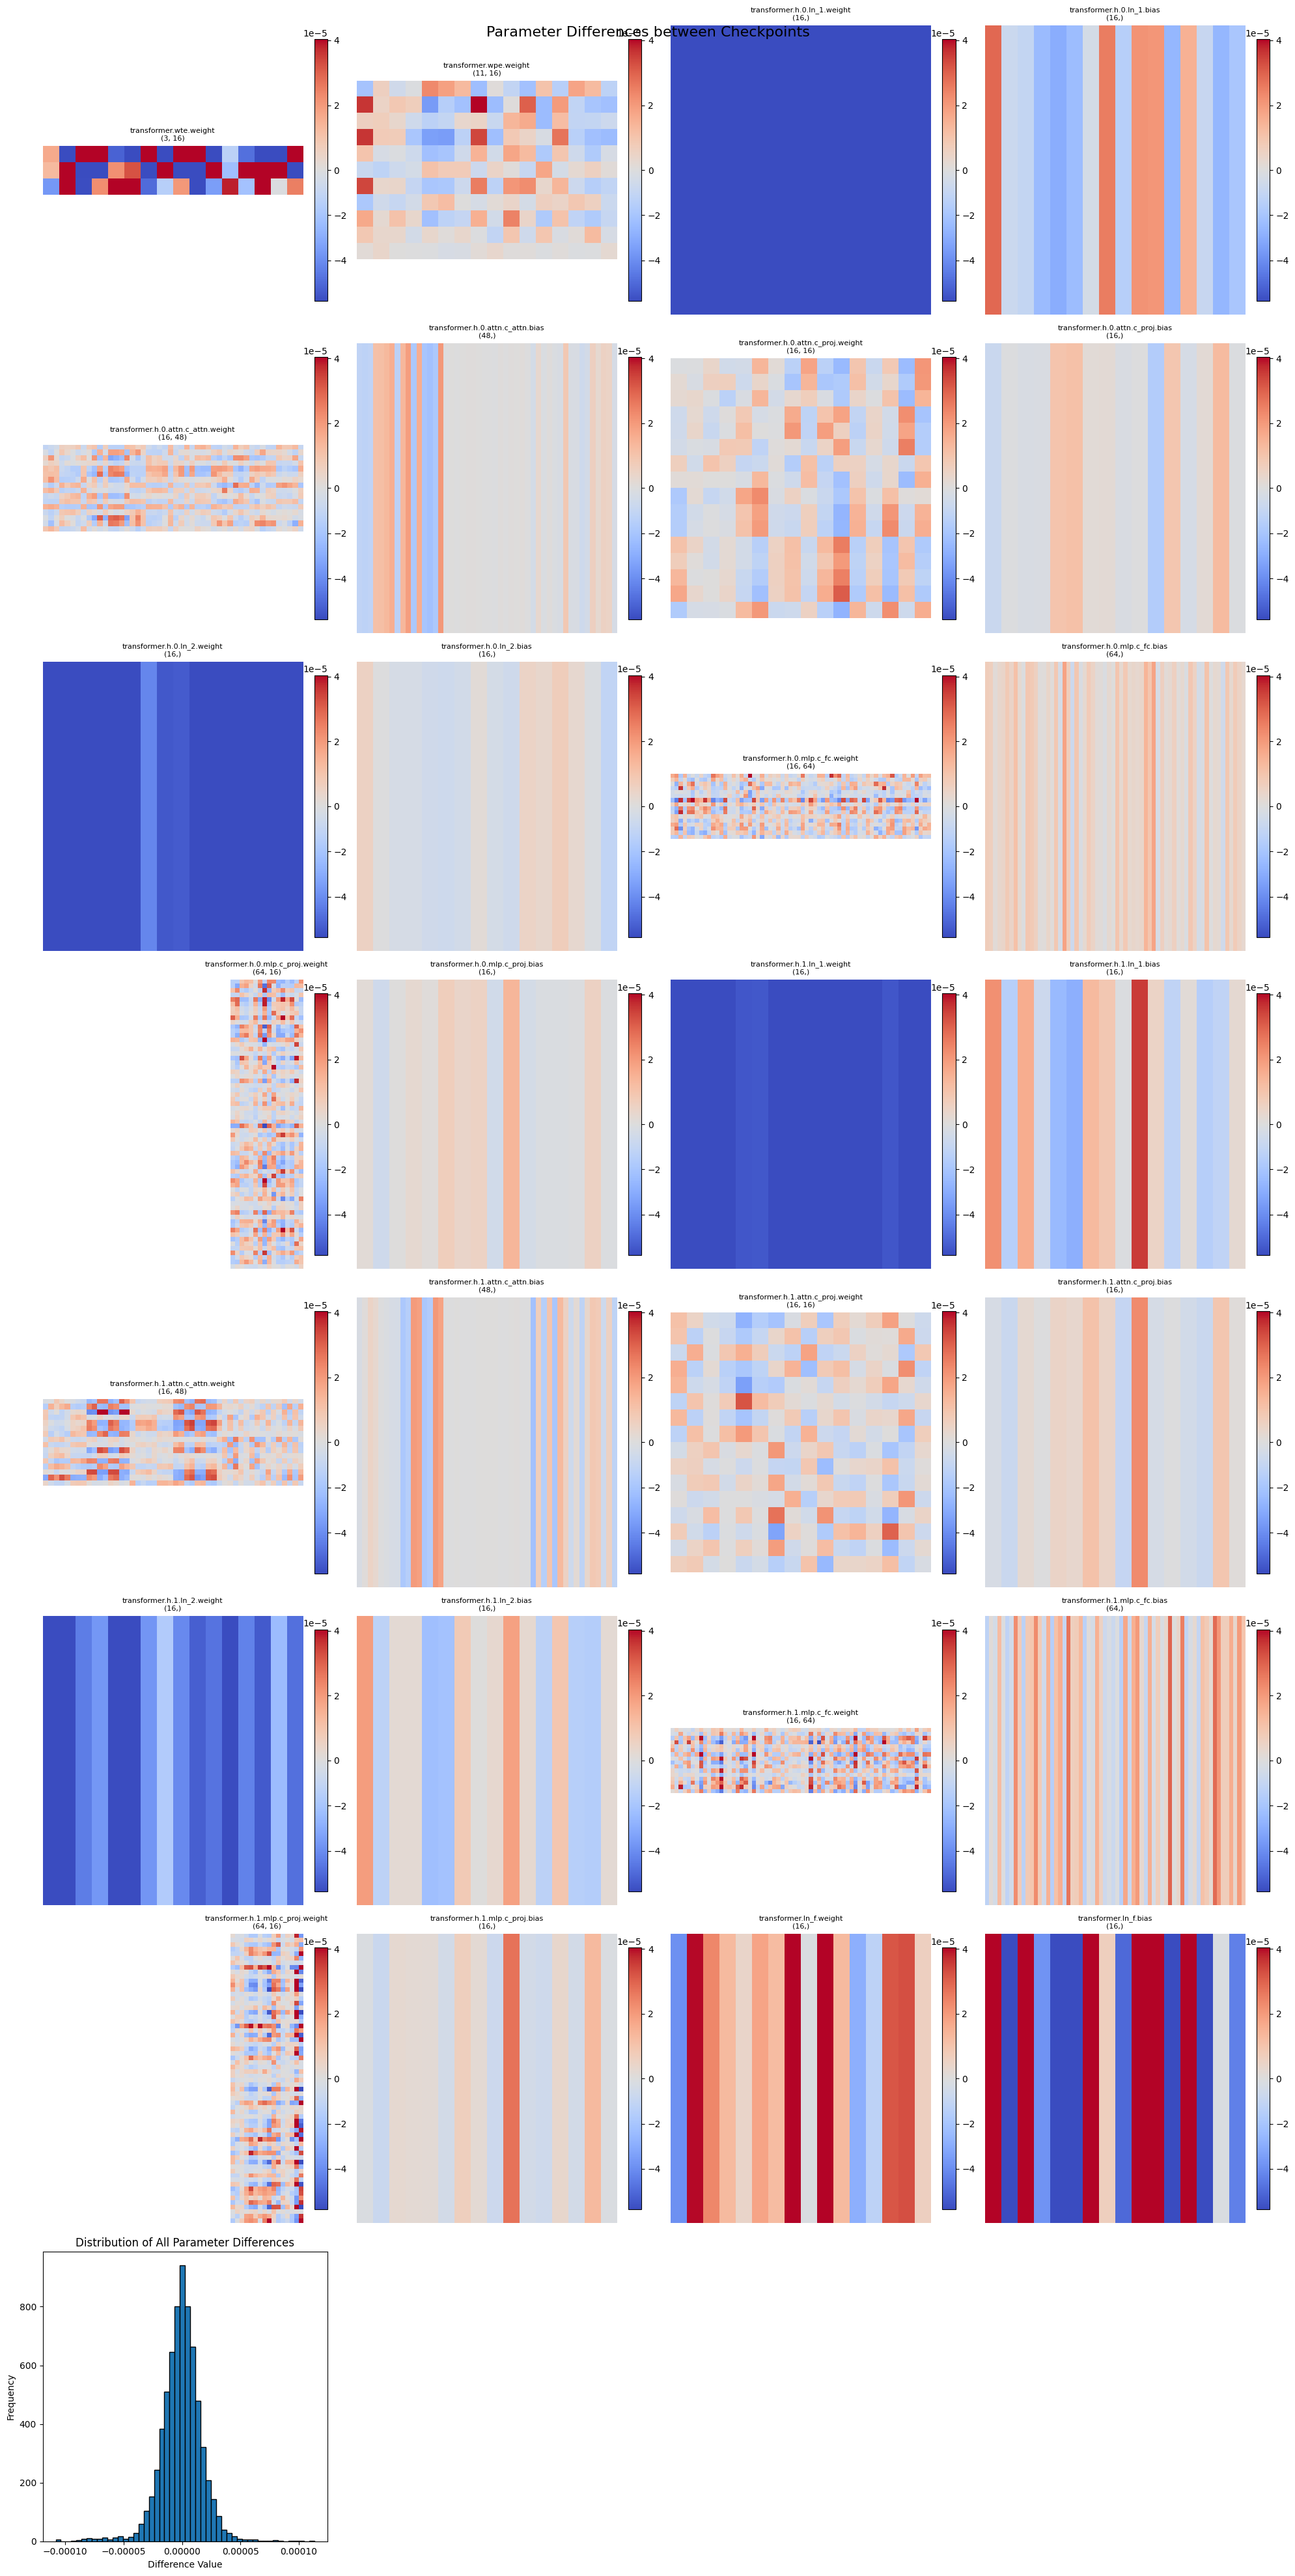


Summary of Parameter Differences:
transformer.wte.weight (3, 16): 0.0004129576846025884
transformer.wpe.weight (11, 16): 0.00018593909044284374
transformer.h.0.ln_1.weight (16,): 0.0003118021704722196
transformer.h.0.ln_1.bias (16,): 8.252778934547678e-05
transformer.h.0.attn.c_attn.weight (16, 48): 0.00033146856003440917
transformer.h.0.attn.c_attn.bias (48,): 6.561251211678609e-05
transformer.h.0.attn.c_proj.weight (16, 16): 0.0001898899645311758
transformer.h.0.attn.c_proj.bias (16,): 2.8558692065416835e-05
transformer.h.0.ln_2.weight (16,): 0.00026845946558751166
transformer.h.0.ln_2.bias (16,): 2.0499792299233377e-05
transformer.h.0.mlp.c_fc.weight (16, 64): 0.0004486386606004089
transformer.h.0.mlp.c_fc.bias (64,): 5.107476681587286e-05
transformer.h.0.mlp.c_proj.weight (64, 16): 0.0004796373541466892
transformer.h.0.mlp.c_proj.bias (16,): 2.0009581930935383e-05
transformer.h.1.ln_1.weight (16,): 0.00028093624860048294
transformer.h.1.ln_1.bias (16,): 6.685113476123661e-05
trans

In [187]:
_, all_diffs_flat = compare_checkpoints(model1, model2, None)

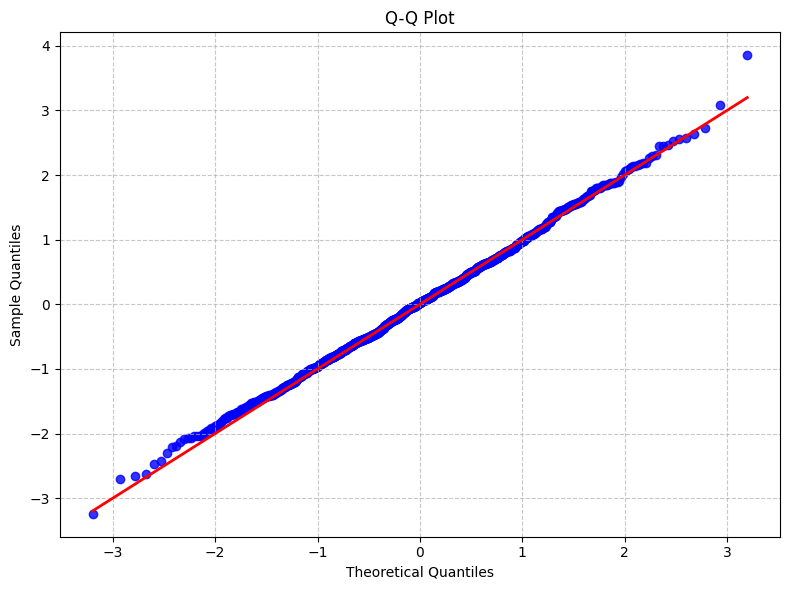

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def create_qq_plot(data):
    # Create Q-Q plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Calculate quantiles
    (quantiles, values), _ = stats.probplot(data, dist="norm", fit=True)
    
    # Plot the points
    ax.scatter(quantiles, values, color='blue', alpha=0.8)
    
    # Plot the line
    line = ax.plot(quantiles, quantiles, color='red', lw=2)
    
    # Customize the plot
    ax.set_title('Q-Q Plot')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')
    
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Example usage
# Generate some sample data (you can replace this with your actual data)
np.random.seed(42)
sample_data = np.random.normal(loc=0, scale=1, size=1000)

# Create the Q-Q plot
create_qq_plot(sample_data)

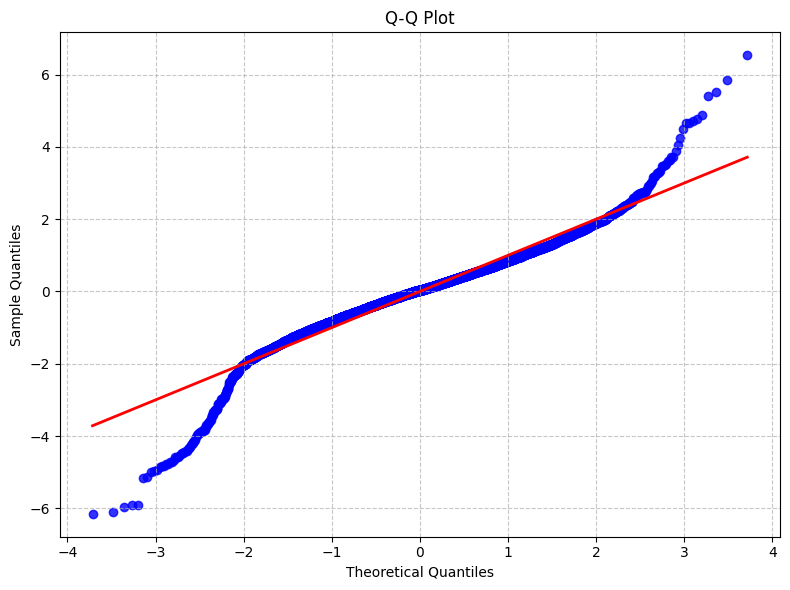

In [189]:
all_diffs_normalized = (all_diffs_flat-np.mean(all_diffs_flat))/np.std(all_diffs_flat)
create_qq_plot(all_diffs_normalized)

In [190]:
def test_normality(data):
    statistic, p_value = stats.shapiro(data)
    print(f"Shapiro-Wilk test statistic: {statistic}")
    print(f"p-value: {p_value}")
    
    alpha = 0.05  # Significance level
    if p_value > alpha:
        print("The data appears to be normally distributed (fail to reject H0)")
    else:
        print("The data does not appear to be normally distributed (reject H0)")


In [191]:
test_normality(all_diffs_normalized)

Shapiro-Wilk test statistic: 0.947449689524018
p-value: 5.608436712223604e-44
The data does not appear to be normally distributed (reject H0)


/mnt/sda/hoyeon/.conda/envs/circuit/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6816.
  res = hypotest_fun_out(*samples, **kwds)


In [192]:
sample_data = np.random.normal(loc=0, scale=1, size=len(all_diffs_normalized))
test_normality(sample_data)

Shapiro-Wilk test statistic: 0.9998770158436707
p-value: 0.9855179522208172
The data appears to be normally distributed (fail to reject H0)


In [193]:
all_diffs_normalized

array([ 0.9932234, -4.436952 ,  4.249794 , ..., -6.1505103, -0.0517955,
       -2.4692812], dtype=float32)